In [1]:
# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader, random_split, TensorDataset   # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
import timeit
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
import os
import pandas as pd
from torch.utils.data import TensorDataset, Dataset
import glob
import cv2
from sklearn.model_selection import train_test_split

In [2]:
!pip install aicrowd-cli

In [3]:
API_KEY = "fd1aed7204268f0bae2780fb808a4063" #Please enter your API Key from [https://www.aicrowd.com/participants/me]
!aicrowd login --api-key 23c297cee1f3012a28f2e3612de488cc

API Key valid
Saved API Key successfully!


In [4]:
!aicrowd dataset download --challenge chunin-exams-food-track-cv-2021

train_images.zip: 100% 754M/754M [00:09<00:00, 78.2MB/s]
test_images.zip: 100% 33.9M/33.9M [00:00<00:00, 62.5MB/s]
train.csv: 100% 253k/253k [00:00<00:00, 2.63MB/s]
test.csv: 100% 7.27k/7.27k [00:00<00:00, 896kB/s]


In [ ]:
!unzip '/content/test_images.zip'
!unzip '/content/train_images.zip'

### Class to read custom dataset in pytorch

In [3]:
class MyDataset(Dataset):
    def __init__(self,data_list,data_dir = './',transform=None,train=True):
        super().__init__()
        self.data_list = data_list
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
    
    def __len__(self):
        return self.data_list.shape[0]
    
    def __getitem__(self,item):
        if self.train:
          img_name,label = self.data_list.iloc[item]
        else:
          img_name = self.data_list.iloc[item]['ImageId']
        img_path = os.path.join(self.data_dir,img_name)
        img = cv2.imread(img_path,1)
        img = cv2.resize(img,(256,256))
        if self.transform is not None:
            img = self.transform(img)
        if self.train:
          return img, torch.tensor(label)
        else:
          return img
          

### Converting string target labels to integer labels

In [4]:
train_label_df = pd.read_csv('train.csv')
#train_label_df = train_label_df.sort_values(by=['ImageId'])
classes = train_label_df['ClassName'].unique()

class2id = {}
id = 0
for target in classes:
  class2id[target] = id
  id += 1
print(class2id)
t = train_label_df["ClassName"].to_numpy()
y = np.zeros(9323)
i = 0
for label in t:
  y[i] = class2id[label]
  i += 1
print(y) 

{'water': 0, 'pizza-margherita-baked': 1, 'broccoli': 2, 'salad-leaf-salad-green': 3, 'egg': 4, 'butter': 5, 'bread-white': 6, 'apple': 7, 'dark-chocolate': 8, 'white-coffee-with-caffeine': 9, 'sweet-pepper': 10, 'mixed-salad-chopped-without-sauce': 11, 'tomato-sauce': 12, 'cucumber': 13, 'cheese': 14, 'pasta-spaghetti': 15, 'rice': 16, 'zucchini': 17, 'salmon': 18, 'mixed-vegetables': 19, 'espresso-with-caffeine': 20, 'banana': 21, 'strawberries': 22, 'mayonnaise': 23, 'almonds': 24, 'bread-wholemeal': 25, 'wine-white': 26, 'hard-cheese': 27, 'ham-raw': 28, 'tomato': 29, 'french-beans': 30, 'mandarine': 31, 'wine-red': 32, 'potatoes-steamed': 33, 'croissant': 34, 'carrot': 35, 'salami': 36, 'boisson-au-glucose-50g': 37, 'biscuits': 38, 'corn': 39, 'leaf-spinach': 40, 'tea-green': 41, 'chips-french-fries': 42, 'parmesan': 43, 'beer': 44, 'bread-french-white-flour': 45, 'coffee-with-caffeine': 46, 'chicken': 47, 'soft-cheese': 48, 'tea': 49, 'avocado': 50, 'bread-sourdough': 51, 'gruyer

In [8]:
y.shape

(9323,)

### Updating the csv read with integer labels

In [5]:
train = pd.read_csv('train.csv')
train['ClassName'].replace(class2id,inplace=True)
train.sample(10)

,ImageId,ClassName
6028,fe8d1d164c.jpg,25
1290,bdf8463caa.jpg,27
1830,7d6da7277f.jpg,35
187,7751de8a89.jpg,43
4536,b6ce41c50b.jpg,43
7751,975ca601a6.jpg,46
531,7d6cc5dea0.jpg,33
6070,dd3ffa9e61.jpg,0
2743,ef77bc7a03.jpg,11
2417,c7fc60d07b.jpg,32


### Confirming the updates in labels

In [10]:
train['ClassName'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

### Data Augmentation
- Random rotation by 45 degree
- Horizontal Flipping by probability of .5 

In [ ]:
mytransforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize( mean = np.array([0.485, 0.456, 0.406]),
    std = np.array([0.229, 0.224, 0.225]))
])
train_path = '/content/train_images'
train_data = MyDataset(data_list= train,data_dir = train_path,transform = mytransforms)


### Spiltting into train, valid and test data

In [20]:
train_dataset, test_data = random_split(train_data,[8000,1323])
train_dataset, valid_dataset = random_split(train_dataset,[6000,2000])

In [21]:
print(train_dataset.__len__(), valid_dataset.__len__(), test_data.__len__())

6000 2000 1323


### Preparing data loader for train, valid and test data to be fed to pytorch models

In [22]:

batch = 64
train_loader = DataLoader(train_dataset, batch_size = batch)
valid_loader = DataLoader(valid_dataset, batch_size = batch)
test_loader = DataLoader(test_data, batch_size = batch)

In [24]:
for x, y in train_loader:
  print(x.shape, y.shape)
  break

for x, y in valid_loader:
  print(x.shape, y.shape)
  break

for x,y in test_loader:
  print(x.shape, y.shape)
  break

torch.Size([64, 3, 256, 256]) torch.Size([64])
torch.Size([64, 3, 256, 256]) torch.Size([64])
torch.Size([64, 3, 256, 256]) torch.Size([64])


### Setting device to GPU to speed up

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### Function to plot Train loss and validation loss per epoch

In [7]:
def plot_losses(train_loss, valid_loss):
  plt.plot(train_loss, '-bx')
  plt.plot(valid_loss, '-rx')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(['Training', 'Validation'])
  plt.title("Loss vs Epoch")

#### Funtion to plot accuracy per epoch during training

In [8]:
def plot_accuracy(accuracy, num_epoch=30):
  #plt.plot(train_loss, '-bx')
  plt.plot(accuracy, '-ro')
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  #plt.legend(['Training', 'Validation'])
  plt.title("Accuracy vs Epoch")

#### Reseting parameters of model

In [9]:
def reset_network_params(model):
  for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
  return model

#### Funtion to calculate accuracy of model

In [10]:

# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    pred = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            #x = x.reshape(x.shape[0],3,200,200)
            y = y.to(device=device).long()
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct/num_samples



### Confusion matrix

In [31]:
import seaborn as sns
# Check accuracy on training & test to see how good our model
def get_confusion_matrix(loader, model):
    with torch.no_grad():
        pred = np.zeros(1)
        actual = np.zeros(1)
        for x, y in loader:
            actual = np.append(actual, y.numpy())
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, predictions = scores.max(1)
            #print(predictions)
            pred = np.append(pred, predictions.cpu().data.numpy())
            #print(i,predictions.shape)
            #i+=1
            #break
    actual = actual[1:]
    pred = pred[1:]
    print(actual.shape, pred.shape)
    print(type(actual), type(pred),pred)
    actual = actual.astype(int)
    pred = pred.astype(int)
    #return actual, pred
    cf_mat = confusion_matrix(list(actual), list(pred) )
    plt.figure(figsize=(9,9))
    sns.heatmap(cf_mat, annot=True)
    #return cf_mat

#cf_mat = get_confusion_matrix(test_loader, model_no_norm)

#cf_mat = confusion_matrix(actual, pred )
#confusion_matrix(list(actual), list(pred) )

#### Training with validation

In [33]:
def TRAIN(model, criterion, optimizer, num_epoch=5):
  start = timeit.default_timer()
  train_loss = []
  valid_loss = []
  accuracy = []
  # Train Network
  for epoch in range(num_epoch):
      tr_loss = 0.0
      for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
          # Get data to cuda if possible
          data = data.to(device=device)
          targets = targets.to(device=device)
          # Get to correct shape
          #data = data.reshape(data.shape[0], -1)
          # forward
          scores = model(data) 
          loss = criterion(scores, targets)
          #print(epoch, loss)
          # backward
          optimizer.zero_grad()
          loss.backward()
          
          # gradient descent or adam step
          optimizer.step()
          tr_loss += loss.item()
      Loss = tr_loss / len(train_loader)
      #print(Loss)
      train_loss.append(Loss)

      #---------  VALIDATION STEP------------------------------------
      val_loss = 0.0
      model.eval()     # Optional when not using Model Specific layer
      for data, labels in valid_loader:
          if torch.cuda.is_available():
              data, labels = data.cuda(), labels.cuda()
          #data = data.reshape(data.shape[0], -1)
          target = model(data)
          loss = criterion(target,labels)
          val_loss += loss.item() #* data.size(0)
      val_loss /= len(valid_loader) 
      valid_loss. append(val_loss)
      #print(val_loss)
      #--------------------------------------------------------------
      #------------- Accuracy at this epoch -------------------------
      acc = check_accuracy(test_loader, model)*100
      accuracy.append(acc) 
      #-------------------------------------------------------------- 
      print("\nEpoch : ",epoch,"  Train Loss : ",Loss,"  Validation Loss : ",val_loss, "  Accuracy :",acc,"\n")
  stop = timeit.default_timer()
  print('Time: ', stop - start)  
  return train_loss, valid_loss, accuracy


### CNN model with 2 layers (Convolution + pooling) followed by2 dense layers

In [35]:
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2), # output: 8 x 16 x 16

            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(24),
            nn.MaxPool2d(2, 2), # output: 24 x 8 x 8

            nn.Flatten(), 
            nn.Linear(16 * 64 * 64, 100),
            nn.ReLU(),
            nn.Linear(100, 61),
            nn.Softmax(dim=1)
            )
        
    def forward(self, x):
        return self.network(x)

In [38]:
# Model # 2 layers
model1 = CNN2() 
#print(model)
model1.to(device)
reset_network_params(model1)
# Loss and optimizer
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(model1.parameters(), lr=0.045, momentum=0.4)
train_loss, valid_loss, accuracy = TRAIN(model1, criterion1, optimizer1, num_epoch=10)



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch :  0   Train Loss :  4.06456269862804   Validation Loss :  4.047178082168102   Accuracy : tensor(9.5994, device='cuda:0') 



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch :  1   Train Loss :  4.047454050246706   Validation Loss :  4.04690508544445   Accuracy : tensor(9.5994, device='cuda:0') 



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch :  2   Train Loss :  4.0474586867271585   Validation Loss :  4.046946883201599   Accuracy : tensor(9.5994, device='cuda:0') 



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch :  3   Train Loss :  4.0473595451801385   Validation Loss :  4.046937063336372   Accuracy : tensor(9.5994, device='cuda:0') 



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch :  4   Train Loss :  4.047360430372522   Validation Loss :  4.046877451241016   Accuracy : tensor(9.5994, device='cuda:0') 



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch :  5   Train Loss :  4.047357599785987   Validation Loss :  4.046858265995979   Accuracy : tensor(9.5994, device='cuda:0') 



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch :  6   Train Loss :  4.0473630986315134   Validation Loss :  4.0468636229634285   Accuracy : tensor(9.5994, device='cuda:0') 



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch :  7   Train Loss :  4.047353825670608   Validation Loss :  4.0468627363443375   Accuracy : tensor(9.5994, device='cuda:0') 



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch :  8   Train Loss :  4.04735447498078   Validation Loss :  4.046858958899975   Accuracy : tensor(9.5994, device='cuda:0') 



100%|██████████| 94/94 [00:52<00:00,  1.80it/s]



Epoch :  9   Train Loss :  4.047352237904326   Validation Loss :  4.046856209635735   Accuracy : tensor(9.5994, device='cuda:0') 

Time:  790.4764308429999


In [40]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model1)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model1)*100:.2f}")


Accuracy on training set: 9.13
Accuracy on test set: 9.60


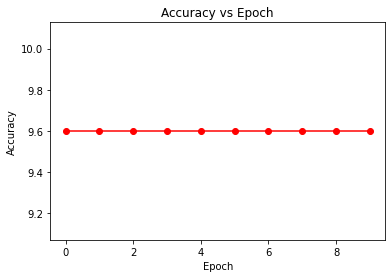

In [41]:
plot_accuracy(accuracy, num_epoch=5)

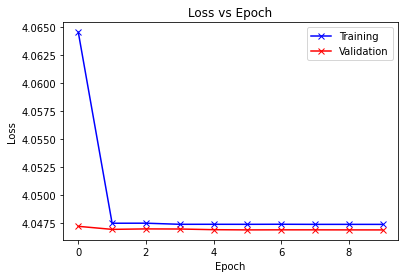

In [42]:
plot_losses(train_loss, valid_loss) 

### CNN model with 3 layers (1 layer = Convolution + Convolution + pooling) followed by 2 dense layers
- Pooling used = average pooling
- Dropout of 0.2 before last dense layer
- Leaky relu used as activation


In [46]:
class CNN_3(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            #nn.BatchNorm2d(8),
            nn.AvgPool2d(2, 2), # output: 8 x 16 x 16

            nn.Conv2d(16, 24, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(24, 48, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(), 
            #nn.BatchNorm2d(24),
            nn.AvgPool2d(2, 2), # output: 24 x 8 x 8

            nn.Conv2d(48, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(), 
            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),  
            #nn.BatchNorm2d(24),
            nn.AvgPool2d(2, 2), # output: 24 x 8 x 8

            nn.Flatten(), 
            nn.Linear(96 * 32 * 32, 1000),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1000, 61),
            nn.Softmax(dim=1)
            )
        
    def forward(self, x):
        return self.network(x)

In [48]:
# Model # 2 layers
model3 = CNN_3() 
#print(model)
model3.to(device)
reset_network_params(model3)
# Loss and optimizer
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.001 ) 
train_loss, valid_loss, accuracy = TRAIN(model3, criterion3, optimizer3, num_epoch=10)



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch :  0   Train Loss :  4.099797279276746   Validation Loss :  4.10593980550766   Accuracy : tensor(4.3084, device='cuda:0') 



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch :  1   Train Loss :  4.098982714592142   Validation Loss :  4.10593980550766   Accuracy : tensor(4.3084, device='cuda:0') 



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch :  2   Train Loss :  4.098982714592142   Validation Loss :  4.10593980550766   Accuracy : tensor(4.3084, device='cuda:0') 



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch :  3   Train Loss :  4.098982714592142   Validation Loss :  4.10593980550766   Accuracy : tensor(4.3084, device='cuda:0') 



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch :  4   Train Loss :  4.098982714592142   Validation Loss :  4.10593980550766   Accuracy : tensor(4.3084, device='cuda:0') 



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch :  5   Train Loss :  4.098982714592142   Validation Loss :  4.10593980550766   Accuracy : tensor(4.3084, device='cuda:0') 



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch :  6   Train Loss :  4.098982714592142   Validation Loss :  4.10593980550766   Accuracy : tensor(4.3084, device='cuda:0') 



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch :  7   Train Loss :  4.098982714592142   Validation Loss :  4.10593980550766   Accuracy : tensor(4.3084, device='cuda:0') 



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch :  8   Train Loss :  4.098982714592142   Validation Loss :  4.10593980550766   Accuracy : tensor(4.3084, device='cuda:0') 



100%|██████████| 94/94 [01:08<00:00,  1.37it/s]



Epoch :  9   Train Loss :  4.098982714592142   Validation Loss :  4.10593980550766   Accuracy : tensor(4.3084, device='cuda:0') 

Time:  974.4492549639999


In [52]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model3)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model3)*100:.2f}")


Accuracy on training set: 3.95
Accuracy on test set: 4.31


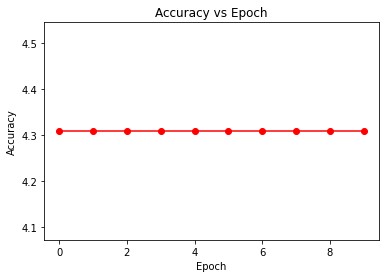

In [53]:
plot_accuracy(accuracy, num_epoch=10)

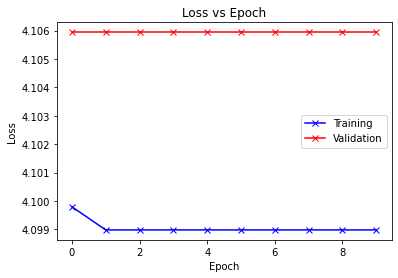

In [54]:
plot_losses(train_loss, valid_loss) 

# Transfer learning using Resnet50 model

In [56]:
batch = 64
train_dataset, valid_dataset = random_split(train_data,[8000,1323])
train_loader = DataLoader(train_dataset, batch_size = batch)
valid_loader = DataLoader(valid_dataset, batch_size = batch)
test_path = '/content/test_images'
test = pd.read_csv('test.csv')
test_data = MyDataset(data_list= test,data_dir = test_path,transform = mytransforms, train=False)
test_loader = DataLoader(test_data, batch_size=batch)

In [62]:
resnet1 = torchvision.models.resnet50(pretrained=True)
resnet1.fc = nn.Linear(resnet1.fc.in_features, 61)
resnet1 = resnet1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet1.parameters(), lr=0.001)


In [11]:
train_loss, valid_loss, accuracy = TRAIN(resnet1, criterion, optimizer, num_epoch=15)


Epoch :  0   Train Loss :  3.0323   Validation Loss :  2.7762   Accuracy : tensor(27.47, device='cuda:0')

Epoch :  1   Train Loss :  2.4754   Validation Loss :  2.6676   Accuracy : tensor(30.63, device='cuda:0')

Epoch :  2   Train Loss :  2.2194   Validation Loss :  2.2815   Accuracy : tensor(39.48, device='cuda:0')

Epoch :  3   Train Loss :  2.0601   Validation Loss :  2.1954   Accuracy : tensor(39.65, device='cuda:0')
 
Epoch :  4   Train Loss :  1.9273   Validation Loss :  2.2665   Accuracy : tensor(40.05, device='cuda:0')

Epoch :  5   Train Loss :  1.8183   Validation Loss :  2.0163   Accuracy : tensor(43.78, device='cuda:0')

Epoch :  6   Train Loss :  1.7302   Validation Loss :  1.9663   Accuracy : tensor(46.89, device='cuda:0')

Epoch :  7   Train Loss :  1.4390   Validation Loss :  1.5005   Accuracy : tensor(55.63, device='cuda:0')

Epoch :  8   Train Loss :  1.3215   Validation Loss :  1.4829   Accuracy : tensor(56.22, device='cuda:0')

Epoch :  9   Train Loss :  1.2715   

In [12]:
print(f"Accuracy on training set: {check_accuracy(train_loader, resnet1)*100:.2f}")
print(f"Accuracy on valid set: {check_accuracy(valid_loader, resnet1)*100:.2f}")


Accuracy on training set:  68.15
Accuracy on valid set:  58.58


### Getting output labels

In [ ]:
y_pred = np.zeros(1)
for data in test_loader:
  x = data.to(device=device)
  outputs = resnet1(x)
  _, preds = torch.max(outputs, 1)
  y = preds.cpu().numpy()
  y_preds = np.append(y) 
y_preds = y_preds[1:].astype(int)

### Writing output csv to drive

In [ ]:
LABELS = {0:'water', 1:'pizza-margherita-baked', 2:'broccoli', 3:'salad-leaf-salad-green', 4:'egg', 5:'butter',
        6:'bread-white', 7:'apple', 8:'dark-chocolate', 9:'white-coffee-with-caffeine', 10:'sweet-pepper',
        11:'mixed-salad-chopped-without-sauce', 12:'tomato-sauce', 13:'cucumber', 14:'cheese', 15:'pasta-spaghetti',
        16:'rice', 17:'zucchini', 18:'salmon', 19:'mixed-vegetables', 20:'espresso-with-caffeine', 21:'banana',
        22:'strawberries', 23:'mayonnaise', 24:'almonds', 25:'bread-wholemeal', 26:'wine-white', 27:'hard-cheese',
        28:'ham-raw', 29:'tomato', 30:'french-beans', 31:'mandarine', 32:'wine-red', 33:'potatoes-steamed', 34:'croissant',
        35:'carrot', 36:'salami', 37:'boisson-au-glucose-50g', 38:'biscuits', 39:'corn', 40:'leaf-spinach', 41:'tea-green',
        42:'chips-french-fries', 43:'parmesan', 44:'beer', 45:'bread-french-white-flour', 46:'coffee-with-caffeine',
        47:'chicken', 48:'soft-cheese', 49:'tea', 50:'avocado', 51:'bread-sourdough', 52:'gruyere', 53:'sauce-savoury',
        54:'honey', 55:'mixed-nuts', 56:'jam', 57:'bread-whole-wheat', 58:'water-mineral', 59:'onion', 60:'pickle'}

with open('/content/drive/MyDrive/CV/resnet_submission.csv', mode='w') as my_file:
      my_writer = csv.writer(my_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      my_writer.writerow(['ClassName'])
      i=0
      while (i<484):
          my_writer.writerow([ LABELS[ y_preds[i] ] ])
          i += 1 

### Freeing up gpu memory when it gives "Not enough memory in gpu" error

In [58]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()